# Modelling column exclusion and over-/underfitting

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

In [2]:
# Import dataframe that has upper 1% of prices excluded, because this was deemed ideal in the previous notebook
dataframe_1p_upper = pd.read_csv("CurrentData/listings_1p_upper.csv")

# Import other dataframes with dropped columns
df_drop_accommodates = pd.read_csv("CurrentData/listings_drop_accommodates.csv")
df_drop_latlon = pd.read_csv("CurrentData/listings_drop_latlon.csv")
df_drop_id = pd.read_csv("CurrentData/listings_drop_id.csv")

# Debugging: 
#df_drop_accommodates = pd.read_csv("CurrentData/listings_drop_final.csv")
#df_drop_latlon = pd.read_csv("CurrentData/listings_drop_final.csv")
#df_drop_id = pd.read_csv("CurrentData/listings_drop_id.csv")

dataframe_list = [
    dataframe_1p_upper,
    df_drop_accommodates,
    df_drop_latlon,
    df_drop_id
]
dataframe_name_list = [
    "minus upper 1%",
    "minus accommodates column",
    "minus lat, lon columns",
    "minus id column"
]

### Re-perform splits and normalization

In [3]:
# Split into train, val, test
random_state = 42 

dataframe_split_list = []

for dataframe in dataframe_list:
    df_train, df_test = train_test_split(dataframe, test_size = 0.2, random_state = random_state, shuffle = True)
    df_train, df_validation = train_test_split(df_train, test_size = 0.2, random_state = random_state, shuffle = True)
    dataframe_split_list.append((df_train, df_validation, df_test))

# Check that this split is the same as in the outliers notebook -> it is the same
#print("For Debugging")
#print(df_train.iloc[:3, :6])

# Split into features and target
def split_dataframe_Xy(df_train, df_validation, df_test):
    # Split dataframe into features and target
    X_train = df_train.drop(columns=["price"])
    y_train = df_train["price"] # Note: is now a pandas series, not a dataframe
    X_test = df_test.drop(columns=["price"])
    y_test = df_test["price"] # Note: -//-
    X_validation = df_validation.drop(columns=["price"])
    y_validation = df_validation["price"] # Note: -//-

    return X_train, y_train, X_validation, y_validation, X_test, y_test

dataframe_ft_split_list = []

for tuple in dataframe_split_list:
    df_train, df_validation, df_test = tuple
    X_train, y_train, X_validation, y_validation, X_test, y_test = split_dataframe_Xy(df_train, df_validation, df_test)
    dataframe_ft_split_list.append((X_train, y_train, X_validation, y_validation, X_test, y_test))   

    print(X_train.iloc[:5, :2])

# Normalize
def normalize(X_train, X_validation, X_test):
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train) # fit mean and std of train data features onto scaler and normalize train data
    X_test_scaled = scaler.transform(X_test)  # Use same mean and std to normalize test data features
    X_validation_scaled = scaler.transform(X_validation) # -//- validation data features

    return X_train_scaled, X_validation_scaled, X_test_scaled

dataframe_ft_split_scaled_list = []

for tuple in dataframe_ft_split_list:
    X_train, y_train, X_validation, y_validation, X_test, y_test = tuple
    X_train_scaled, X_validation_scaled, X_test_scaled = normalize(X_train, X_validation, X_test)
    dataframe_ft_split_scaled_list.append((X_train_scaled, y_train, X_validation_scaled, y_validation, X_test_scaled, y_test))


                id  host_is_superhost
5954  1.010096e+18                0.0
4788  8.062313e+17                0.0
3593  5.292862e+07                0.0
8257  1.313234e+18                0.0
161   5.892850e+05                0.0
                id  host_is_superhost
5954  1.010096e+18                0.0
4788  8.062313e+17                0.0
3593  5.292862e+07                0.0
8257  1.313234e+18                0.0
161   5.892850e+05                0.0
                id  host_is_superhost
5954  1.010096e+18                0.0
4788  8.062313e+17                0.0
3593  5.292862e+07                0.0
8257  1.313234e+18                0.0
161   5.892850e+05                0.0
      host_is_superhost  host_listings_count
5954                0.0                  2.0
4788                0.0                  2.0
3593                0.0                  1.0
8257                0.0                  1.0
161                 0.0                  1.0


## Test exclusion of columns

#### MSE vs Alpha graphs for 1p_upper with different columns excluded

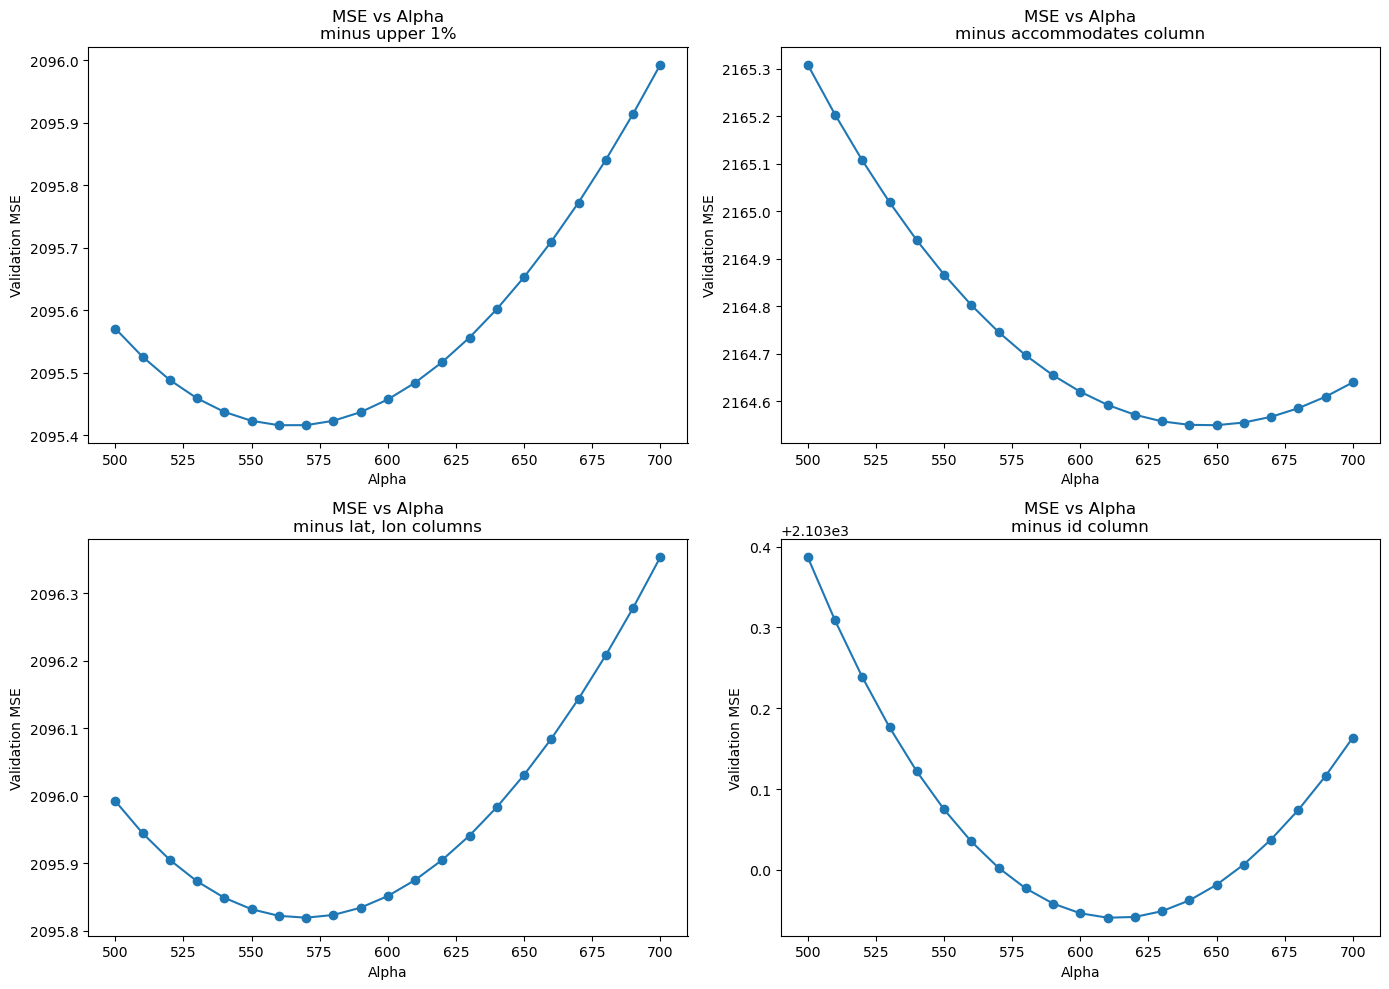

In [4]:
fig, axes = plt.subplots(2, 2, figsize = (14, 10), sharex = False, sharey = False)
axes = axes.flatten()  # Flatten for easy indexing with 0, 1, 2, 3

name_index = 0

for tuple in dataframe_ft_split_scaled_list:  # Only plot 4 datasets
    X_train_scaled, y_train, X_validation_scaled, y_validation, X_test_scaled, y_test = tuple

    alphas = [
        500.0, 510.0, 520.0, 530.0, 540.0, 550.0, 560.0, 570.0, 580.0, 590.0, 
        600.0, 610.0, 620.0, 630.0, 640.0, 650.0, 660.0, 670.0, 680.0, 690.0, 
        700.0
    ]

    ridge_mse_results = []

    for alpha in alphas:
        model = Ridge(alpha = alpha)
        model.fit(X_train_scaled, y_train)

    # Commented out code for when you also need MSE on train and test data    
        #y_train_pred = model.predict(X_train_scaled)
        y_val_pred = model.predict(X_validation_scaled)
        #y_test_pred = model.predict(X_test_scaled)

        #mse_train = mean_squared_error(y_train, y_train_pred)
        mse_val = mean_squared_error(y_validation, y_val_pred)
        #mse_test = mean_squared_error(y_test, y_test_pred)

        ridge_mse_results.append((alpha, mse_val))
        #ridge_mse_results.append((alpha, mse_train, mse_val, mse_test))

    alphas_plot, mse_val_plot = zip(*ridge_mse_results)
    #alphas_plot, _, mse_val_plot, _ = zip(*ridge_mse_results)

    ax = axes[name_index]
    ax.plot(alphas_plot, mse_val_plot, marker='o')
    #ax.set_xscale("log")
    ax.set_xlabel("Alpha")
    ax.set_ylabel("Validation MSE")
    ax.set_title(f"MSE vs Alpha\n{dataframe_name_list[name_index]}")
    ax.grid(False)

    name_index += 1

plt.tight_layout()
plt.show()

### Conclusion:
<div style="font-size: 1.2em; font-weight: 500;">
The exclusion of the "accomodates" column visibly worsens performance of the model. So, as expected, this feature is vital for the modell.<br>
Excluding the unnamed index column, while worsening performance very slightly, has minimal effect on performance. This makes sense, as there shouldn't usually be a strong link between listing id and price. Same for the latitude, longitude columns. <br>
Thus, we can indeed safely exclude the lat, lon and id columns from our data in advance. This will be done in the DataCleaning file.
</div>

### Compare validation mse to training mse to check for over-/underfitting

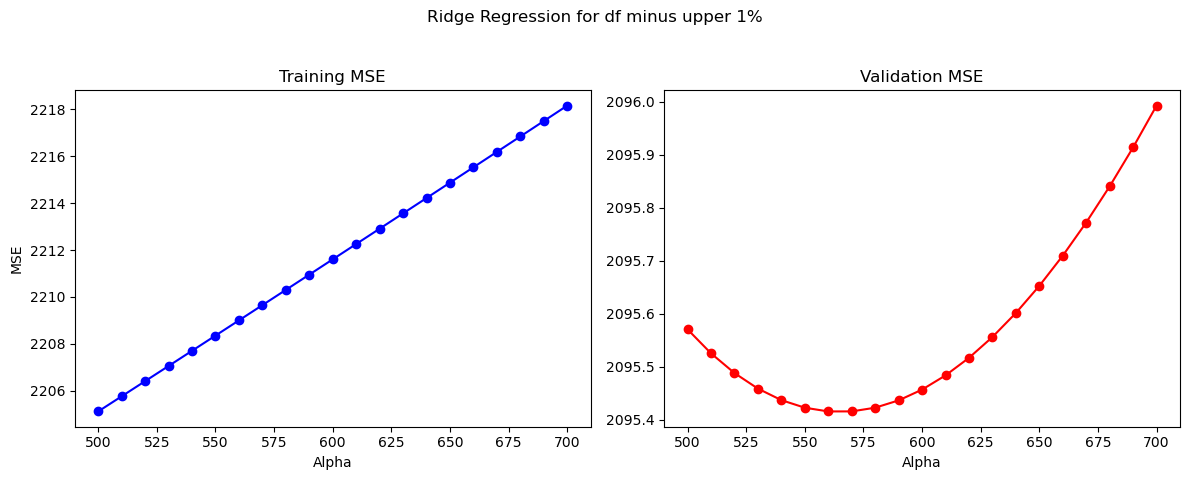

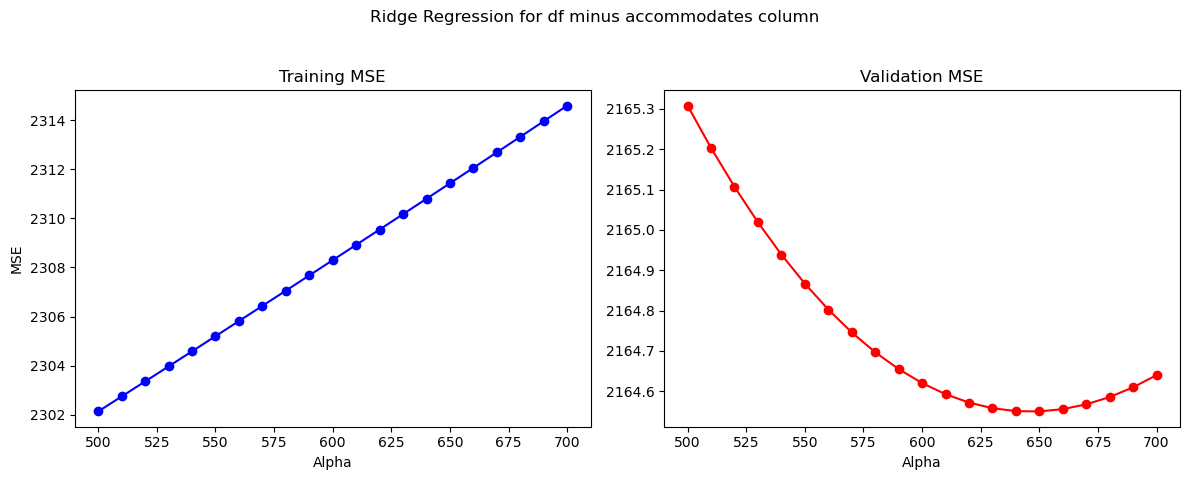

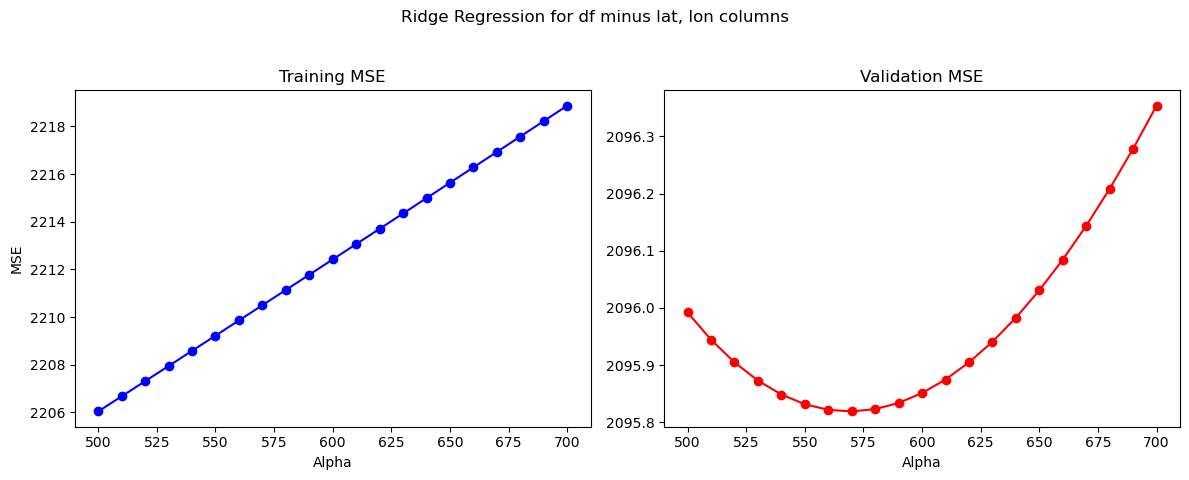

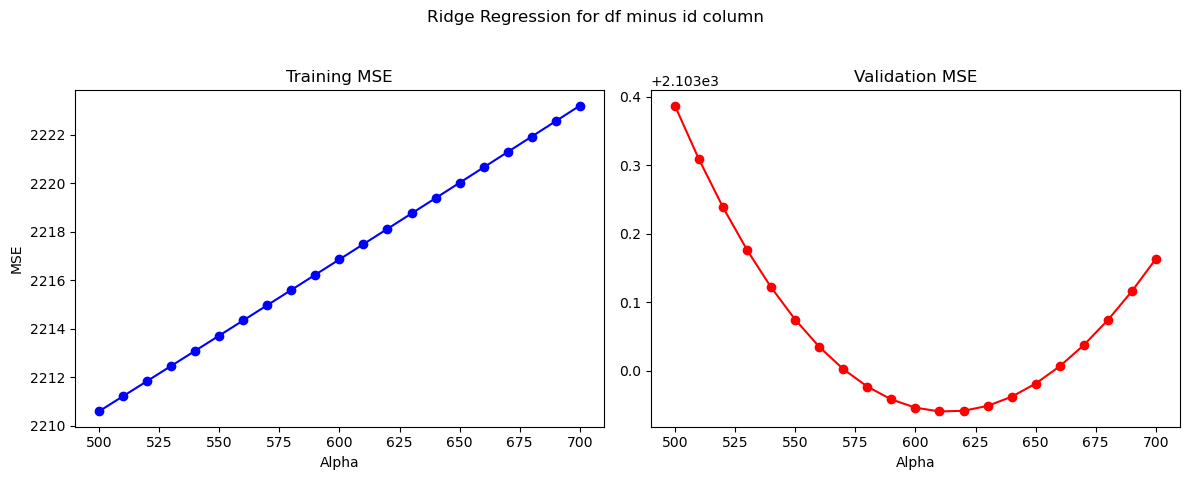

In [5]:
name_index = 0

for tuple in dataframe_ft_split_scaled_list:

    X_train_scaled, y_train, X_validation_scaled, y_validation, X_test_scaled, y_test = tuple

    # List of alphas to try
    alphas = [
    500.0,
    510.0,
    520.0,
    530.0,
    540.0,
    550.0,
    560.0,
    570.0,
    580.0,
    590.0,
    600.0,
    610.0,
    620.0,
    630.0,
    640.0,
    650.0,
    660.0,
    670.0,
    680.0,
    690.0,
    700.0
    ]    

    ridge_mse_results = []
    
    for alpha in alphas:
        model = Ridge(alpha = alpha)
        model.fit(X_train_scaled, y_train)

        y_train_pred = model.predict(X_train_scaled)
        y_val_pred = model.predict(X_validation_scaled)
        y_test_pred = model.predict(X_test_scaled)

        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_val = mean_squared_error(y_validation, y_val_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)

        ridge_mse_results.append((alpha, mse_train, mse_val, mse_test))

    # Unpack and split up results
    alphas_plot, mse_train_plot, mse_val_plot, _ = zip(*ridge_mse_results)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot training MSE
    axes[0].plot(alphas_plot, mse_train_plot, marker = "o", color="blue")
    #axes[0].set_xscale("log")
    axes[0].set_title("Training MSE")
    axes[0].set_xlabel("Alpha")
    axes[0].set_ylabel("MSE")
    axes[0].grid(False)

    # Plot validation MSE
    axes[1].plot(alphas_plot, mse_val_plot, marker = "o", color= "red")
    #axes[1].set_xscale("log")
    axes[1].set_title("Validation MSE")
    axes[1].set_xlabel("Alpha")
    axes[1].grid(False)

    fig.suptitle(f"Ridge Regression for df {dataframe_name_list[name_index]}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    name_index += 1

### Conclusion:
<div style="font-size: 1.2em; font-weight: 500;">
Higher MSE on the training data than on the validation data might indicate that we are seeing slight underfitting on the training data, but in exchange hopefully will have better performance on general/ test data.<br>
Also, as is to be expected, for higher alpha, meaning more regularization, the MSE on the training data rises.
</div>

## Check MSE on test data

In [6]:
# Import dataframe without id and without lat, lon
dataframe = pd.read_csv("CurrentData/listings_drop_final.csv")

# Split data into train and test blocks
random_state = 42

df_train, df_test = train_test_split(dataframe, test_size = 0.2, random_state = random_state, shuffle = True)

# Split into features and target
X_train, y_train, _, _, X_test, y_test = split_dataframe_Xy(df_train, df_train, df_test)

In [9]:
# Normalize and standardize train+val data combined 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Ridge(alpha = 610) # ideal alpha from testing
model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_test_pred)
print(f"MSE: {mse:.2f}")

rmse = mse ** 0.5
print(f"RMSE: {rmse:.2f}")

mar = mean_absolute_error(y_test, y_test_pred)
print(f"Mean absolute error: {mar:.2f}")

MSE: 2054.05
RMSE: 45.32
Mean absolute error: 32.29


## MSE for listings_drop_final: 2054. The RMSE is 45

### The mean absolute error is about 32. This means that on average, our modell prediction is off by about 32, when guessing the price on the test set.